# TADs vs boundaries vs non-TADs analysis

In [4]:
input_file = "tad.nontad.br.bed" #file from Sonal
tad_output_file = "tad.bed"
nontad_output_file = "nontad.bed"
tadbr_output_file = "tadbr.bed"

# Open the input file and output files
with open(input_file, "r") as infile, open(tad_output_file, "w") as tad_outfile, open(nontad_output_file, "w") as nontad_outfile, open(tadbr_output_file, "w") as tadbr_outfile:
    # Iterate through each line in the input file
    for line in infile:
        # Split the line into columns
        columns = line.strip().split("\t")
        # Check the value in col6 (columns[5]) and write to the corresponding output file
        if columns[5] == "TAD":
            tad_outfile.write("\t".join(columns[:3]) + "\n")
        elif columns[5] == "nonTAD":
            nontad_outfile.write("\t".join(columns[:3]) + "\n")
        elif columns[5] == "tadbr":
            tadbr_outfile.write("\t".join(columns[:3]) + "\n")

In [26]:
import os
working_directory = '/scratch/ak8725/az_mrg/TADs_boundaries/'
os.chdir(working_directory)

from pybedtools import BedTool

# Create a dictionary to store BedTool objects with their names as keys
bedtools_dict = {
    'pro': BedTool('/scratch/ak8725/az_mrg/fitcons/from_zoe/PRO-seq.bedgraph'),
    'exp': BedTool('/scratch/ak8725/expression/Azu_field2017_Normal.bed')
}

# Define the list of input region files
input_region_files = [
    'tad.bed',
    'tadbr.bed',
    'nontad.bed'
]

# Calculate the mean feature value per region for each dataset
for obj_name, obj in bedtools_dict.items():
    for region_file in input_region_files:
        output_name = f'{obj_name}_{region_file.split(".")[0]}.txt'  # Generate output file name based on object name and region file

        regions = BedTool(region_file)

        result = regions.map(obj, c=4, o='mean', output=output_name)

        print(f'Mean {obj_name} per region calculated, output saved as {output_name}')


Mean pro per region calculated, output saved as pro_tad.txt
Mean pro per region calculated, output saved as pro_tadbr.txt
Mean pro per region calculated, output saved as pro_nontad.txt
Mean exp per region calculated, output saved as exp_tad.txt
Mean exp per region calculated, output saved as exp_tadbr.txt
Mean exp per region calculated, output saved as exp_nontad.txt


***** WARNING: File tad.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1572500	1622500

***** WARNING: File tad.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1572500	1622500

***** WARNING: File tadbr.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1567500	1572500

Error: Sorted input specified, but the file tadbr.bed has the following out of order record
chr01	277500	282500
***** WARNING: File nontad.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1	1567499

***** WARNING: File nontad.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1	1567499

***** WARNING: File tad.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1572500	1622500

***** WARNING: File tad.bed has a record where naming convention (lead

TAD: Mean=0.63, Median=0.63
NonTAD: Mean=0.64, Median=0.64
TADBR: Mean=0.67, Median=0.64


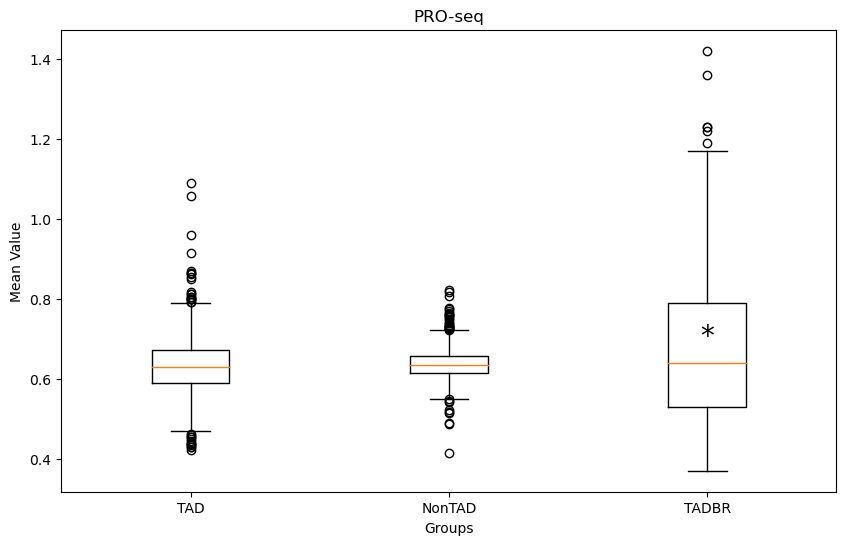

In [73]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load the data from the pro_tad.txt, pro_nontad.txt, and pro_tadbr.txt files
pro_tad = pd.read_csv('pro_tad.txt', sep='\t', header=None, names=["chr", "start", "stop", "Mean_Value"])
pro_nontad = pd.read_csv('pro_nontad.txt', sep='\t', header=None, names=["chr", "start", "stop", "Mean_Value"])
pro_tadbr = pd.read_csv('pro_tadbr.txt', sep='\t', header=None, names=["chr", "start", "stop", "Mean_Value"])

# Define a function to filter out non-numeric values
def filter_numeric(df):
    return df[pd.to_numeric(df['Mean_Value'], errors='coerce').notna()]

# Filter non-numeric values for each DataFrame
pro_tad = filter_numeric(pro_tad)
pro_nontad = filter_numeric(pro_nontad)
pro_tadbr = filter_numeric(pro_tadbr)

# Convert the "Mean_Value" column to numeric for each DataFrame
pro_tad['Mean_Value'] = pd.to_numeric(pro_tad['Mean_Value'])
pro_nontad['Mean_Value'] = pd.to_numeric(pro_nontad['Mean_Value'])
pro_tadbr['Mean_Value'] = pd.to_numeric(pro_tadbr['Mean_Value'])

# Create a list of data frames for each dataset
data_frames = [pro_tad, pro_nontad, pro_tadbr]
labels = ['TAD', 'NonTAD', 'TADBR']

# Calculate and print the mean and median
for df, label in zip(data_frames, labels):
    mean_value = df['Mean_Value'].mean()
    median_value = df['Mean_Value'].median()
    print(f'{label}: Mean={mean_value:.2f}, Median={median_value:.2f}')

# Create a boxplot for each dataset
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot([df['Mean_Value'] for df in data_frames], labels=labels)
plt.title('PRO-seq')
plt.xlabel('Groups')
plt.ylabel('Mean Value')

# Add an asterisk right above the TADBR boxplot
x_position = 3  # Index of the TADBR boxplot
y_position = max(data_frames[2]['Mean_Value']) - 0.75 # Adjust the vertical position as needed
plt.annotate('*', xy=(x_position, y_position), fontsize=20, ha='center', va='bottom')

plt.show()


In [1]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Load the data from the previously generated files and filter out non-numeric values
pro_tad = pd.read_csv('pro_tad.txt', sep='\t', header=None, names=["chr", "start", "stop", "Mean_Value"], na_values=['.'])
pro_tadbr = pd.read_csv('pro_tadbr.txt', sep='\t', header=None, names=["chr", "start", "stop", "Mean_Value"], na_values=['.'])
pro_nontad = pd.read_csv('pro_nontad.txt', sep='\t', header=None, names=["chr", "start", "stop", "Mean_Value"], na_values=['.'])

# Drop rows with missing (NaN) values in the "Mean_Value" column
pro_tad.dropna(subset=['Mean_Value'], inplace=True)
pro_tadbr.dropna(subset=['Mean_Value'], inplace=True)
pro_nontad.dropna(subset=['Mean_Value'], inplace=True)

# Perform t-tests
t_statistic_tad_tadbr, p_value_tad_tadbr = ttest_ind(pro_tad['Mean_Value'], pro_tadbr['Mean_Value'])
t_statistic_tad_nontad, p_value_tad_nontad = ttest_ind(pro_tad['Mean_Value'], pro_nontad['Mean_Value'])
t_statistic_tadbr_nontad, p_value_tadbr_nontad = ttest_ind(pro_tadbr['Mean_Value'], pro_nontad['Mean_Value'])

# Perform multiple testing correction (Benjamini-Hochberg method)
p_values = [p_value_tad_tadbr, p_value_tad_nontad, p_value_tadbr_nontad]
reject, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Print the results
print(f"TAD vs. TADBR: T-statistic = {t_statistic_tad_tadbr}, p-value = {adjusted_p_values[0]}")
print(f"TAD vs. NONTAD: T-statistic = {t_statistic_tad_nontad}, p-value = {adjusted_p_values[1]}")
print(f"TADBR vs. NONTAD: T-statistic = {t_statistic_tadbr_nontad}, p-value = {adjusted_p_values[2]}")

TAD vs. TADBR: T-statistic = -6.613203477501527, p-value = 1.4556769986777325e-10
TAD vs. NONTAD: T-statistic = -1.2235217600826462, p-value = 0.22129089845601568
TADBR vs. NONTAD: T-statistic = 4.6821690814661485, p-value = 4.685052173621672e-06


TAD: Mean=9.73, Median=4.58
NonTAD: Mean=9.67, Median=6.30
TADBR: Mean=19.55, Median=2.00


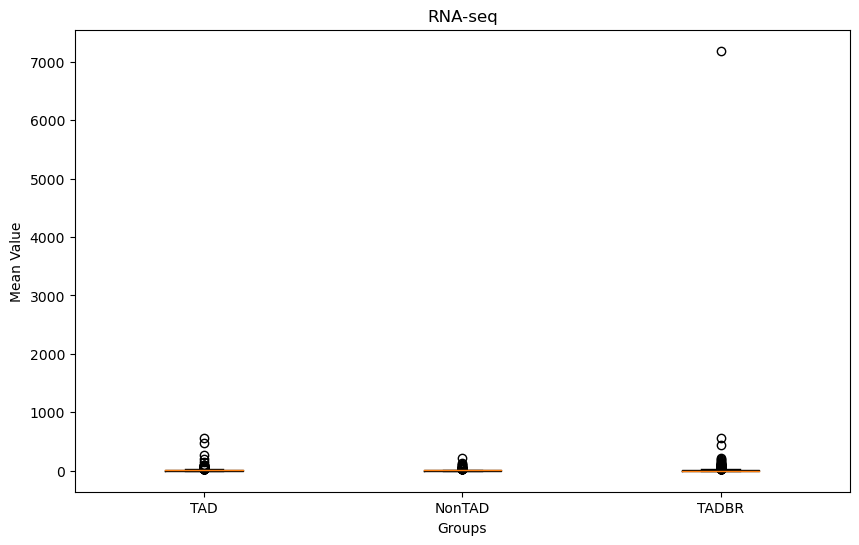

In [35]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load the data from the pro_tad.txt, pro_nontad.txt, and pro_tadbr.txt files
pro_tad = pd.read_csv('exp_tad.txt', sep='\t', header=None, names=["chr", "start", "stop", "Mean_Value"])
pro_nontad = pd.read_csv('exp_nontad.txt', sep='\t', header=None, names=["chr", "start", "stop", "Mean_Value"])
pro_tadbr = pd.read_csv('exp_tadbr.txt', sep='\t', header=None, names=["chr", "start", "stop", "Mean_Value"])

# Define a function to filter out non-numeric values
def filter_numeric(df):
    return df[pd.to_numeric(df['Mean_Value'], errors='coerce').notna()]

# Filter non-numeric values for each DataFrame
pro_tad = filter_numeric(pro_tad)
pro_nontad = filter_numeric(pro_nontad)
pro_tadbr = filter_numeric(pro_tadbr)

# Convert the "Mean_Value" column to numeric for each DataFrame
pro_tad['Mean_Value'] = pd.to_numeric(pro_tad['Mean_Value'])
pro_nontad['Mean_Value'] = pd.to_numeric(pro_nontad['Mean_Value'])
pro_tadbr['Mean_Value'] = pd.to_numeric(pro_tadbr['Mean_Value'])

# Create a list of data frames for each dataset
data_frames = [pro_tad, pro_nontad, pro_tadbr]
labels = ['TAD', 'NonTAD', 'TADBR']

# Calculate and print the mean and median
for df, label in zip(data_frames, labels):
    mean_value = df['Mean_Value'].mean()
    median_value = df['Mean_Value'].median()
    print(f'{label}: Mean={mean_value:.2f}, Median={median_value:.2f}')

# Create a boxplot for each dataset
plt.figure(figsize=(10, 6))
plt.boxplot([df['Mean_Value'] for df in data_frames], labels=labels)
plt.title('RNA-seq')
plt.xlabel('Groups')
plt.ylabel('Mean Value')
plt.show()
